# Online convex optimization (OCO)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import time
sns.set()

All algorithms below come with a parameter 'proj' defining if a projection on the $l_1$-ball of radius $z$ is done.  
Let us recall some notations and definitions.  
- $a$: training examples (features)  
- $b$: training labels  
- $x$: parameter of interest i.e. SVM decision function slope
- $\lambda$: regularization parameter
- $z$: $l_1$-ball radius if 'proj' is set to True

## Gradient descent

In [2]:
#Cost function: regularized hinge loss
def hingereg(x, a, b, lamb):
    cost = np.maximum(0, 1 - a.dot(x)*b)
    
    return np.mean(cost) + lamb*np.sum(x**2)/2

#The corresponding gradient
def gradreg(x, a, b, lamb):
    threshold = a.dot(x)*b # define hard-margin SVM
    gradient = a.apply(lambda x: -b*x, axis=0)
    gradient.loc[threshold >= 1] = 0
    
    return np.mean(gradient, axis=0) + lamb*x #lamb*x ?

#Projection on the simplex
def pisimplex(v, z=1):
    n = len(v)
    u = np.sort(v)[::-1]
    su = np.cumsum(u)
    rho = np.max(np.where(u > np.divide(su-z, np.arange(1, n+1))))
    theta = (su[rho] - z) / rho
    w = np.maximum(v - theta, 0)
    
    return w 

#Projection on the l1-ball
def pib1(x, z=1):
    v = np.abs(x)
    if (np.sum(v) > z):
        u = pisimplex(v, z)
        x = np.sign(x)*u
    return x

In [3]:
def GD(a, b, init, iters=100, lamb=1, proj=False, z=np.inf, cost=hingereg, grad=gradreg):
    x = init
    params = pd.DataFrame(np.arange(init.size).reshape(-1, init.size))
    params.loc[0] = x
    costs = [cost(x, a, b, lamb)]
    
    for i in range(1, iters):
        eta = 1./i
        x = x - eta*grad(x, a, b, lamb)
        if proj: x = pib1(x, z) #Optional projection step on the l1-ball
        params.loc[i] = np.asarray(x)
        costs.append(cost(x, a, b, lamb))
        
    print("Final cost: {0:7f}".format(costs[-1]))
    
    return params, costs

## Online gradient descent

In [4]:
#Cost function: instantaneous regularized hinge loss
def insthingereg(x, a, b, lamb):
    cost = np.maximum(0, 1 - a.dot(x)*b)
    return(cost + lamb*np.sum(x**2)/2)

#The instataneous gradient
def instgradreg(x, a, b, lamb):
    threshold = a.dot(x)*b # define hard-margin SVM
    if threshold >= 1: gradient = np.zeros(x.shape[0])
    else: gradient = -b*a
    
    return gradient + lamb*x #lamb*x ?

In [5]:
#Online gradient descent
def OGD(a, b, init, lamb=1, proj=False, z=np.inf, cost=insthingereg, instgrad=instgradreg):
    x = init
    params = pd.DataFrame(np.arange(init.size).reshape(-1, init.size))
    params.loc[0] = x
    costs = [cost(init, a.loc[0], b[0], lamb)]
  
    for i in range(1, len(b)):
        eta = 1./(lamb*(i))
        
        x = x - eta*instgrad(x, a.loc[i], b[i], lamb)
        if proj: x = pib1(x, z)
        params.loc[i] = np.asarray(x)
        costs.append(costs[-1] + cost(x, a.loc[i], b[i], lamb)) #Will be used to calculate regret
    
    print("Final cost (sum): {0:7f}".format(costs[-1]))
    
    return params, costs

## Online mirrored descent

In [6]:
#Online mirrored descent
def OMD(a, b, init, lamb=1, proj=False, z=np.inf, cost=insthingereg, instgrad=instgradreg):
    x = init
    theta = init
    params = pd.DataFrame(np.arange(init.size).reshape(-1, init.size))
    params.loc[0] = x
    costs = [cost(init, a.loc[0], b[0], lamb)]
  
    for i in range(1, len(b)):
        eta = 1./(lamb*(i))
        theta = theta - eta*instgrad(x, a.loc[i], b[i], lamb)
        x = pib1(theta, z)
        params.loc[i] = np.asarray(x)
        costs.append(costs[-1] + cost(x, a.loc[i], b[i], lamb)) #Will be used to calculate regret
        
    print("Final cost (sum): {0:7f}".format(costs[-1]))
    
    return params, costs

##  Stochastic gradient descent

In [7]:
from numpy.random import choice

def SGD(a, b, init, iters=None, lamb=1, proj=False, z=np.inf, cost=hingereg, instgrad=instgradreg):
    x = init
    M = init
    params = pd.DataFrame(np.arange(init.size).reshape(-1, init.size))
    params.loc[0] = x
    costs = [cost(M, a, b, lamb)]
    
    if iters is None: iters = b.size
    for i in range(1, iters):
        ind = choice(b.size)
#         eta = 1./(lamb*i)
        eta = 1/np.sqrt(i)
        x = x - eta*instgrad(x, a.iloc[ind, :], b.iloc[ind], lamb) #iteration
        if proj: x = pib1(x, z)
        M = (i*M + x)/(i+1)
        
        if i % 100 == 0: params.loc[i] = np.asarray(M)
        costs.append(cost(M, a, b, lamb))
        
    print("Final cost: {0:7f}".format(costs[-1]))
    
    return params, costs

## Stochastic mirrored descent

In [8]:
def SMD(a, b, init, iters=None, lamb=1, z=np.inf, cost=hingereg, instgrad=instgradreg):
    x = init
    theta = init
    M = init
    params = pd.DataFrame(np.arange(init.size).reshape(-1, init.size))
    params.loc[0] = x
    costs = [cost(M, a, b, lamb)]
                 
    if iters is None: iters = b.size
    for i in range(1, iters):
        ind = choice(b.size)
#         eta = 1./(lamb*i)
        eta = 1/np.sqrt(i)
        theta = theta - eta*instgrad(x, a.iloc[ind, :], b.iloc[ind], lamb)
        x = pib1(theta, z)
        M = (i*M + x)/(i+1)
        
        if i % 100 == 0: params.loc[i] = np.asarray(M)
        costs.append(cost(M, a, b, lamb))
        
    print("Final cost: {0:7f}".format(costs[-1]))
    
    return params, costs

## Stochastic exponentiated gradient +/-

In [9]:
def SEGpm(a, b, iters=None, lamb=1, z=np.inf, cost=hingereg, instgrad=instgradreg):
    m = a.shape[1]
    
    W = np.ones(2*m) #weights
    w = W/np.sum(W) #normalized weights
    x = z*(w[:m] - w[m:2*m])
    params = pd.DataFrame(np.arange(m).reshape(-1, m))
    params.loc[0] = x
    M = x.copy()
    costs = [cost(M, a, b, lamb)]
    
    if iters is None: iters = b.size
    for i in range(1, iters):
        ind = choice(b.size)
        eta = 2*np.sqrt(np.log(2*m)/i)
        instg = instgrad(x, a.iloc[ind, :], b.iloc[ind], lamb)
        
        W = np.r_[np.exp(-eta*instg), np.exp(eta*instg)]*W
        w = W/np.sum(W)
        x = z*(w[:m] - w[m:2*m])
        M = (i*M + x)/(i+1)
        
        if i % 100 == 0: params.loc[i] = np.asarray(M)
        costs.append(cost(M, a, b, lamb))
  
    print("Final cost: {0:7f}".format(costs[-1]))
    
    return params, costs 

## AdaGrad

In [10]:
def pib1w(x, w, z=1):
    if np.sum(np.abs(x)) > z and z != np.inf:
        v = np.abs(x*w)
        u = np.argsort(-v)
        sx = np.cumsum(np.abs(x)[u])
        sw = np.cumsum(1/w[u])
        rho = np.max(np.where(v[u] > (sx - z)/sw))
        theta = (sx[rho] - z)/sw[rho]
        x = np.sign(x)*np.maximum(np.abs(x) - theta/w, 0)
        
    return x

def AdaGrad(a, b, init, iters=None, lamb=1, z=np.inf, cost=hingereg, instgrad=instgradreg):
    m = a.shape[1]
    s = np.ones(m)/(4*m)
    x = init
    M = init
    params = pd.DataFrame(np.arange(m).reshape(-1, m))
    params.loc[0] = x
    costs = [cost(M, a, b, lamb)]
  
    if iters is None: iters = b.size
    eta = 1/(lamb*np.sqrt(iters)) #Constant lr
    for i in range(1, iters):
        ind = choice(b.size)
        s = s + instgrad(x, a.iloc[ind, :], b.iloc[ind], lamb)**2
        y = x - eta*(1/np.sqrt(s))*instgrad(x, a.iloc[ind, :], b.iloc[ind], lamb)
        x = pib1w(y, np.sqrt(s), z)
        M = (i*M + x)/(i+1)
        
        if i % 100 == 0: params.loc[i] = np.asarray(M)
        costs.append(cost(M, a, b, lamb))
    
    print("Final cost: {0:7f}".format(costs[-1]))
    
    return params, costs

## Pegasos

In [11]:
def Pegasos(a, b, init, iters=None, lamb=1, proj=False, z=np.inf, cost=hingereg):
    x = init
    M = init
    params = pd.DataFrame(np.arange(init.size).reshape(-1, init.size))
    params.loc[0] = x
    costs = [cost(M, a, b, lamb)]
    
    if iters is None: iters = b.size
    for i in range(1, iters):
        ind = choice(b.size)
        eta = 1/(lamb*i)
        
        a_, b_ = a.iloc[ind, :], b.iloc[ind]
        if b_*x.dot(a_) < 1:
            x = (1 - eta*lamb)*x + eta*b_*a_
        else:
            x = (1 - eta*lamb)*x
        
        if proj: x = pib1(x, z)
        M = (i*M + x)/(i+1)
    
        if i % 100 == 0: params.loc[i] = np.asarray(M)
        costs.append(cost(M, a, b, lamb))
    
    print("Final cost: {0:7f}".format(costs[-1]))
    
    return params, costs

## MNIST dataset

### Preprocessing

In [12]:
#Importing data
train = pd.read_csv("Data/mnist_train.csv", delimiter=',')
test = pd.read_csv("Data/mnist_test.csv", delimiter=',')
train.head()

,5,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.608,0.609,0.610,0.611,0.612,0.613,0.614,0.615,0.616,0.617
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
print("Train shape :", train.shape)
print("Test shape :", test.shape)

Train shape : (59999, 785)
Test shape : (9999, 785)


In [14]:
b_train = train.iloc[:, 0]
a_train = train.drop(['5'], axis=1)
display(a_train.head())
display(b_train.head())

b_test = test.iloc[:, 0]
a_test = test.drop(['5'], axis=1)

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.608,0.609,0.610,0.611,0.612,0.613,0.614,0.615,0.616,0.617
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


0    0
1    4
2    1
3    9
4    2
Name: 5, dtype: int64

In [15]:
#Checking if missing values
print(np.any(pd.isnull(a_train)))
print(np.any(pd.isnull(a_test)))

False
False


### Data preprocessing

In [16]:
#Sampling data as dataset is too large
idx_train = choice(np.arange(a_train.shape[0]), 10000, replace=False)
idx_test = choice(np.arange(a_test.shape[0]), 3000, replace=False) #Test set size is 30% of training set size

a_train = a_train.loc[idx_train]
a_test = a_test.loc[idx_test]
b_train = b_train[idx_train]
b_test = b_test[idx_test]
print("Train shape :", a_train.shape)
print("Test shape :", a_test.shape)

Train shape : (10000, 784)
Test shape : (3000, 784)


In [17]:
#Scaling data
a_train = a_train/255
a_test = a_test/255

In [18]:
#0 (-1) vs all
b_train[b_train == 0] = -1
b_train[b_train > 0] = 1
b_test[b_test == 0] = -1
b_test[b_test > 0] = 1

In [19]:
print(b_train.value_counts())
print(b_test.value_counts())

 1    9020
-1     980
Name: 5, dtype: int64
 1    2713
-1     287
Name: 7, dtype: int64


## Numerical experiments on MNIST

In [20]:
#IMPORTANT: set seed for reproductible experiments
np.random.seed(117)

times = [] #to store training times 

In [21]:
def ratehat(params, a=a_test, b=b_test):
    return np.mean((b[:, np.newaxis]*np.dot(a, params.T))>0, axis=0)

### GD vs PGD

In [22]:
x0 = np.zeros(a_train.shape[1])
lamb = 1/3.
iters = 100
xrange = np.arange(1, iters+1)

In [23]:
start = time.time()
paramsGD, costsGD = GD(a = a_train, 
              b = b_train, 
              init = x0, 
              iters = iters, 
              lamb = lamb)
end = time.time()
print("Time: {0:3f}s".format(end-start))
times.append(end-start)

start = time.time()
paramsPGD, costsPGD = GD(a = a_train, 
              b = b_train, 
              init = x0, 
              iters = iters, 
              lamb = lamb, 
              proj = True,
              z = 10)
end = time.time()
print("Time: {0:3f}s".format(end-start))
times.append(end-start)

Final cost: 0.172004
Time: 35.079582s
Final cost: 0.136650
Time: 35.416039s


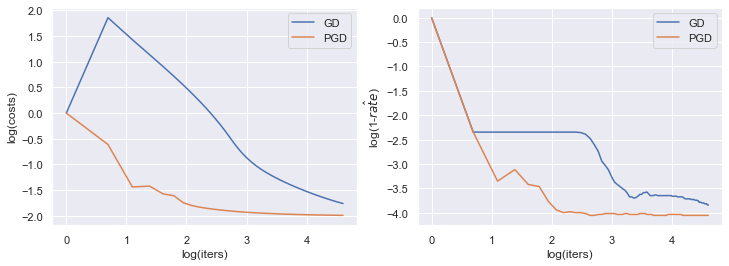

In [24]:
ratesGD = ratehat(paramsGD)
ratesPGD = ratehat(paramsPGD)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(np.log(xrange), np.log(costsGD), label='GD')
ax[0].plot(np.log(xrange), np.log(costsPGD), label='PGD')
ax[0].set_xlabel('log(iters)')
ax[0].set_ylabel('log(costs)')
ax[0].legend()

ax[1].plot(np.log(xrange), np.log(1-ratesGD), label='GD')
ax[1].plot(np.log(xrange), np.log(1-ratesPGD), label='PGD')
ax[1].set_xlabel('log(iters)')
ax[1].set_ylabel(r'log(1-$\hat{rate}$)')
ax[1].legend()

There is a huge improvement using projection on the $l_1-$ball.

### SGD vs SMD

In [25]:
x0 = np.zeros(a_train.shape[1])
lamb = 1/3.
iters = 10000
xrange = np.arange(1, iters+1)

In [26]:
start = time.time()
paramsSGD, costsSGD = SGD(a = a_train, 
                          b = b_train, 
                          iters = iters, 
                          init = x0, 
                          lamb = lamb, 
                          proj = True, 
                          z = 10
                         )
end = time.time()
print("Time: {0:3f}s".format(end-start))
times.append(end-start)

start = time.time()
paramsSMD, costsSMD = SMD(a = a_train, 
                          b = b_train, 
                          iters = iters, 
                          init = x0,
                          lamb = lamb, 
                          z = 10
                         )
end = time.time()
print("Time: {0:3f}s".format(end-start))
times.append(end-start)

Final cost: 0.148069
Time: 47.182096s
Final cost: 0.140983
Time: 54.039201s


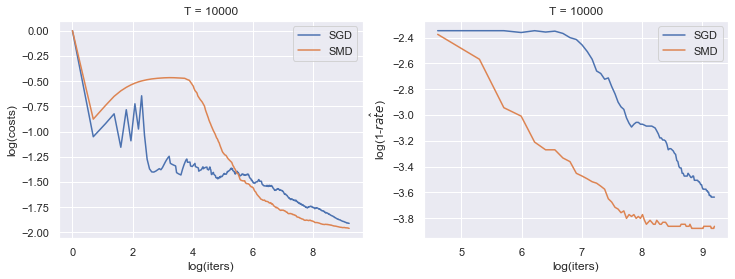

In [27]:
ratesSGD = ratehat(paramsSGD)
ratesSMD = ratehat(paramsSMD)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(np.log(xrange), np.log(costsSGD), label='SGD')
ax[0].plot(np.log(xrange), np.log(costsSMD), label='SMD')
ax[0].set_xlabel('log(iters)')
ax[0].set_ylabel('log(costs)')
ax[0].set_title('T = '+str(iters))
ax[0].legend()

# ax[1].plot(np.log(xrange), np.log(1-ratesSGD), label='SGD')
# ax[1].plot(np.log(xrange), np.log(1-ratesSMD), label='SMD')
ax[1].plot(np.log(np.arange(0, iters, step=100)), np.log(1-ratesSGD), label='SGD')
ax[1].plot(np.log(np.arange(0, iters, step=100)), np.log(1-ratesSMD), label='SMD')
ax[1].set_xlabel('log(iters)')
ax[1].set_ylabel(r'log(1-$\hat{rate}$)')
ax[1].set_title('T = '+str(iters))
ax[1].legend();

### SEGpm vs AdaGrad

In [28]:
x0 = np.zeros(a_train.shape[1])
lamb = 1/3.
iters = 10000
xrange = np.arange(1, iters+1)

In [29]:
start = time.time()
paramsSEGpm, costsSEGpm = SEGpm(a = a_train, 
                                b = b_train, 
                                iters = iters, 
                                lamb = lamb, 
                                z = 10
                               )
end = time.time()
print("Time: {0:3f}s".format(end-start))
times.append(end-start)

start = time.time()
paramsAda, costsAda = AdaGrad(a = a_train,
                              b = b_train, 
                              iters = iters, 
                              init = x0,
                              lamb = lamb,
                              z = 10
                              )
end = time.time()
print("Time: {0:3f}s".format(end-start))
times.append(end-start)

Final cost: 0.135835
Time: 32.929930s
Final cost: 0.135886
Time: 59.443470s


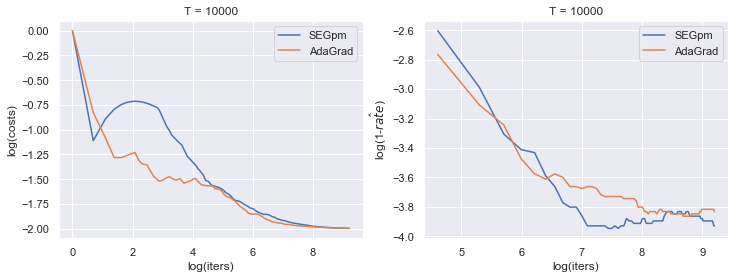

In [30]:
ratesSEGpm = ratehat(paramsSEGpm)
ratesAda = ratehat(paramsAda)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(np.log(xrange), np.log(costsSEGpm), label='SEGpm')
ax[0].plot(np.log(xrange), np.log(costsAda), label='AdaGrad')
ax[0].set_xlabel('log(iters)')
ax[0].set_ylabel('log(costs)')
ax[0].set_title('T = '+str(iters))
ax[0].legend()

# ax[1].plot(np.log(xrange), np.log(1-ratesSEGpm), label='SEGpm')
# ax[1].plot(np.log(xrange), np.log(1-ratesAda), label='AdaGrad')
ax[1].plot(np.log(np.arange(0, iters, step=100)), np.log(1-ratesAda), label='SEGpm')
ax[1].plot(np.log(np.arange(0, iters, step=100)), np.log(1-ratesSEGpm), label='AdaGrad')
ax[1].set_xlabel('log(iters)')
ax[1].set_ylabel(r'log(1-$\hat{rate}$)')
ax[1].set_title('T = '+str(iters))
ax[1].legend();

### SGD vs Pegasos

In [31]:
x0 = np.zeros(a_train.shape[1])
lamb = 1/3.
iters = 10000
xrange = np.arange(1, iters+1)

In [32]:
# start = time.time()
# paramsSGD, costsSGD = SGD(a = a_train, 
#                           b = b_train, 
#                           iters = iters, 
#                           init = x0, 
#                           lamb = lamb, 
#                           proj = True, 
#                           z = 10
#                          )
# end = time.time()
# print("Time: {0:3f}s".format(end-start))

start = time.time()
paramsPegasos, costsPegasos = Pegasos(a = a_train, 
                                      b = b_train, 
                                      iters = iters, 
                                      init = x0, 
                                      lamb = lamb, 
                                      proj = True,
                                      z = 10
                                     )
end = time.time()
print("Time: {0:3f}s".format(end-start))
times.append(end-start)

Final cost: 0.135810
Time: 42.059062s


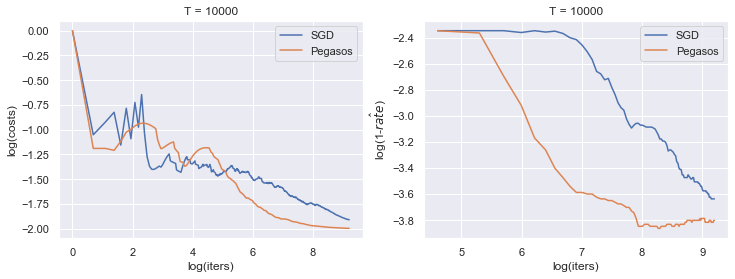

In [33]:
ratesSGD = ratehat(paramsSGD)
ratesPegasos = ratehat(paramsPegasos)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(np.log(xrange), np.log(costsSGD), label='SGD')
ax[0].plot(np.log(xrange), np.log(costsPegasos), label='Pegasos')
ax[0].set_xlabel('log(iters)')
ax[0].set_ylabel('log(costs)')
ax[0].set_title('T = '+str(iters))
ax[0].legend()

# ax[1].plot(np.log(xrange), np.log(1-ratesSGD), label='SGD')
# ax[1].plot(np.log(xrange), np.log(1-ratesPegasos), label='Pegasos')
ax[1].plot(np.log(np.arange(0, iters, step=100)), np.log(1-ratesSGD), label='SGD')
ax[1].plot(np.log(np.arange(0, iters, step=100)), np.log(1-ratesPegasos), label='Pegasos')
ax[1].set_xlabel('log(iters)')
ax[1].set_ylabel(r'log(1-$\hat{rate}$)')
ax[1].set_title('T = '+str(iters))
ax[1].legend();

### Comparing all algorithms

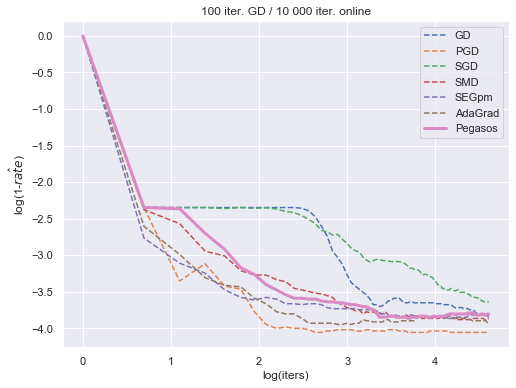

In [34]:
plt.figure(figsize=(8, 6))

plt.plot(np.log(np.arange(1, 101)), np.log(1-ratesGD), linestyle='--', label='GD')
plt.plot(np.log(np.arange(1, 101)), np.log(1-ratesPGD), linestyle='--', label='PGD')
plt.plot(np.log(np.arange(1, 101)), np.log(1-ratesSGD), linestyle='--', label='SGD')
plt.plot(np.log(np.arange(1, 101)), np.log(1-ratesSMD), linestyle='--', label='SMD')
plt.plot(np.log(np.arange(1, 101)), np.log(1-ratesSEGpm), linestyle='--', label='SEGpm')
plt.plot(np.log(np.arange(1, 101)), np.log(1-ratesAda), linestyle='--', label='AdaGrad')
plt.plot(np.log(np.arange(1, 101)), np.log(1-ratesPegasos), linewidth=3, label='Pegasos')
plt.xlabel('log(iters)') 
plt.ylabel(r'log(1-$\hat{rate}$)')
plt.title('100 iter. GD / 10 000 iter. online')
plt.legend();

In [35]:
df = pd.DataFrame(np.array(times).reshape(1, 7), columns=['GD', 'PGD', 'SGD', 'SMD', 'SEGpm', 'AdaGrad', 'Pegasos'], 
                  index=['Training time (s)'])
df

,GD,PGD,SGD,SMD,SEGpm,AdaGrad,Pegasos
Training time (s),35.079582,35.416039,47.182096,54.039201,32.92993,59.44347,42.059062


## Hyperparameters tuning

We can try to observe the influence of the regularization parameter $\lambda$ on the performance of Pegasos. In particular, we can see what happens in the extreme cases i.e. with under-regularization ($\lambda = 0.001$) and over-regularization ($\lambda = 100$).

In [36]:
rates, final_costs = [], []
lamb_range = [1e-3, 1/5, 1/3, 1, 2, 5, 10]
for lamb in lamb_range:
    params, costs = Pegasos(a = a_train, 
                            b = b_train, 
                            iters = iters, 
                            init = x0, 
                            lamb = lamb, 
                            proj = True,
                            z = 10
                            )
    final_costs.append(costs[-1])
    rates.append(ratehat(params)[-1])

Final cost: 0.279014
Final cost: 0.112333
Final cost: 0.135835
Final cost: 0.208019
Final cost: 0.260297
Final cost: 0.343933
Final cost: 0.435897


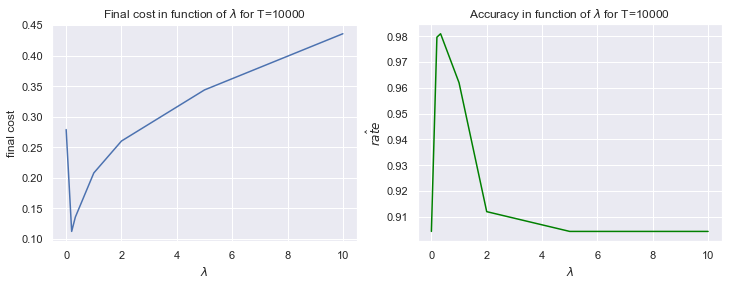

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(lamb_range, final_costs)
ax[0].set_xlabel(r'$\lambda$')
ax[0].set_ylabel('final cost')
ax[0].set_title(r'Final cost in function of $\lambda$ for T=10000')

ax[1].plot(lamb_range, rates, color='green')
ax[1].set_xlabel(r'$\lambda$')
ax[1].set_ylabel(r'$\hat{rate}$')
ax[1].set_title(r'Accuracy in function of $\lambda$ for T=10000');